In [1]:
import pandas as pd

# traj_spacegroup_df = pd.read_pickle("trajectory_spacegroup.pkl")

dir_path = "../LaDe/"

In [2]:
traj_spacegroup_df = pd.read_pickle("../processed/trajectory_spacegroup.pkl")


In [3]:
traj_postman_ids =  traj_spacegroup_df["postman_id"].drop_duplicates()
traj_postman_ids = pd.DataFrame(traj_postman_ids,columns=["postman_id"])

In [ ]:
# # detailed_trajectory = pd.read_pickle(dir_path+"./data_with_trajectory_20s/courier_detailed_trajectory_20s.pkl.xz",compression="xz")
# road_df=pd.read_csv(dir_path+"./road-network/roads.csv",sep="\t")
# road_df = road_df[road_df["city"]=="重庆市"] #重庆市 = "Chongqing City" 

In [4]:
traj_spacegroup_df["mmdd_start"]=traj_spacegroup_df["start_time"].str.slice(0,5).str.replace("-","").astype(int)
traj_spacegroup_df["mmdd_end"]=traj_spacegroup_df["end_time"].str.slice(0,5).str.replace("-","").astype(int)

In [19]:
import lzma, pickle

# delivery_df = pd.read_csv("./delivery/delivery_sh.csv")
# delivery_df = pd.read_csv("./delivery/delivery_sh.csv")
# Try reading the xz-compressed pickle explicitly to avoid LZMAError
try:
    delivery_df = pd.read_pickle("../LaDe/data_with_trajectory_20s/delivery_five_cities.pkl.xz", compression="xz")
except Exception as e:
    # Fallbacks: try infer/no compression or manual lzma+pickle load
    try:
        delivery_df = pd.read_pickle("../LaDe/data_with_trajectory_20s/delivery_five_cities.pkl.xz", compression=None)
    except Exception:
        with lzma.open("../LaDe/data_with_trajectory_20s/delivery_five_cities.pkl.xz", "rb") as f:
            delivery_df = pickle.load(f)

# delivery_df_ch = delivery_df[delivery_df["from_city_name"]=="重庆市"] 
delivery_users = delivery_df[["delivery_user_id","from_city_name"]].drop_duplicates()
# delivery_df_ch = delivery_df[delivery_df["from_city_name"]=="重庆市"] 
delivery_users = delivery_df[["delivery_user_id","from_city_name"]].drop_duplicates()


LZMAError: Input format not supported by decoder

In [ ]:
user_city = traj_postman_ids.merge(
    delivery_users,
    left_on="postman_id",
    right_on = "delivery_user_id",
    how="left"
)

In [ ]:
traj_spacegroup_df = traj_spacegroup_df.merge(user_city,on="postman_id",how="left")

In [ ]:
traj_spacegroup_df_small =  traj_spacegroup_df[ traj_spacegroup_df["from_city_name"].notna() ].copy()

In [ ]:
traj_spacegroup_df_small["start_dt"] = pd.to_datetime(
    "2020-" + traj_spacegroup_df_small["start_time"],
    format="%Y-%m-%d %H:%M:%S"
)

traj_spacegroup_df_small["end_dt"] = pd.to_datetime(
    "2020-" + traj_spacegroup_df_small["end_time"],
    format="%Y-%m-%d %H:%M:%S"
)



In [ ]:
traj_spacegroup_df_small["start_date"] = traj_spacegroup_df_small["start_dt"].dt.date
traj_spacegroup_df_small["end_date"]   = traj_spacegroup_df_small["end_dt"].dt.date

In [ ]:
start_date = traj_spacegroup_df_small["start_date"].min()
end_date   = traj_spacegroup_df_small["end_date"].max()
start_date_str = start_date.strftime("%Y-%m-%d")
end_date_str   = end_date.strftime("%Y-%m-%d")

print("Start date:", start_date_str)
print("End date:", end_date_str)

Start date: 2020-03-21
End date: 2020-04-20


In [ ]:
city_coords = {
    "杭州市": (30.2741, 120.1551),   # Hangzhou
    "重庆市": (29.5630, 106.5516),   # Chongqing
    "上海市": (31.2304, 121.4737)    # Shanghai
}

In [ ]:
import requests

weather_list = []

for city, (lat, lon) in city_coords.items():
    
    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&start_date={start_date_str}&end_date={end_date_str}"
        "&hourly=temperature_2m,relativehumidity_2m,precipitation,windspeed_10m"
    )
    
    data = requests.get(url).json()
    
    df = pd.DataFrame({
        "datetime": pd.to_datetime(data["hourly"]["time"]),
        "temperature": data["hourly"]["temperature_2m"],
        "humidity": data["hourly"]["relativehumidity_2m"],
        "rain": data["hourly"]["precipitation"],
        "wind_speed": data["hourly"]["windspeed_10m"],
    })
    
    df["date"] = df["datetime"].dt.date
    df["hour"] = df["datetime"].dt.hour
    df["from_city_name"] = city
    
    weather_list.append(df)

weather_df_all = pd.concat(weather_list, ignore_index=True)


In [ ]:
traj_spacegroup_df_small["date"] = traj_spacegroup_df_small["start_dt"].dt.date
traj_spacegroup_df_small["hour"] = traj_spacegroup_df_small["start_dt"].dt.hour
traj_with_weather = traj_spacegroup_df_small.merge(
    weather_df_all,
    on=["from_city_name", "date", "hour"],
    how="left"
)

In [ ]:
traj_with_weather = traj_with_weather.sort_values(["postman_id", "start_dt"])

traj_with_weather["time_gap_s"] = (
    traj_with_weather["start_dt"] - traj_with_weather["end_dt"].shift()
).dt.total_seconds()


In [ ]:
import numpy as np

traj_with_weather["dist_m"] = (
    traj_with_weather.groupby("postman_id")
    .apply(lambda g: np.sqrt((g["lat"].diff())**2 + (g["lng"].diff())**2))
    .reset_index(level=0, drop=True)
)


C:\Users\saran\AppData\Local\Temp\ipykernel_13076\1851001375.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.sqrt((g["lat"].diff())**2 + (g["lng"].diff())**2))


In [ ]:
MAX_GAP_S = 5 * 60   # 5 minutes
valid = (traj_with_weather["time_gap_s"] > 0) & (traj_with_weather["time_gap_s"] <= MAX_GAP_S)

traj_with_weather["speed_mps"] = np.where(
    valid,
    traj_with_weather["dist_m"] / traj_with_weather["time_gap_s"],
    np.nan
)

traj_with_weather["speed_kmph"] = traj_with_weather["speed_mps"] * 3.6


In [ ]:
traj_with_weather["date"] = traj_with_weather["start_dt"].dt.date
traj_with_weather["hour"] = traj_with_weather["start_dt"].dt.hour


In [ ]:
df_hourly = traj_with_weather.groupby(
    ["from_city_name", "date", "hour"], as_index=False
).agg({
    "speed_kmph": "mean",
    "temperature": "mean",
    "rain": "mean"
})

In [ ]:
cq_hourly = df_hourly[df_hourly["from_city_name"] == "重庆市"].copy()


In [ ]:
cq_hourly["datetime"] = pd.to_datetime(cq_hourly["date"].astype(str)) + pd.to_timedelta(cq_hourly["hour"], unit="h")
cq_hourly = cq_hourly.sort_values("datetime")

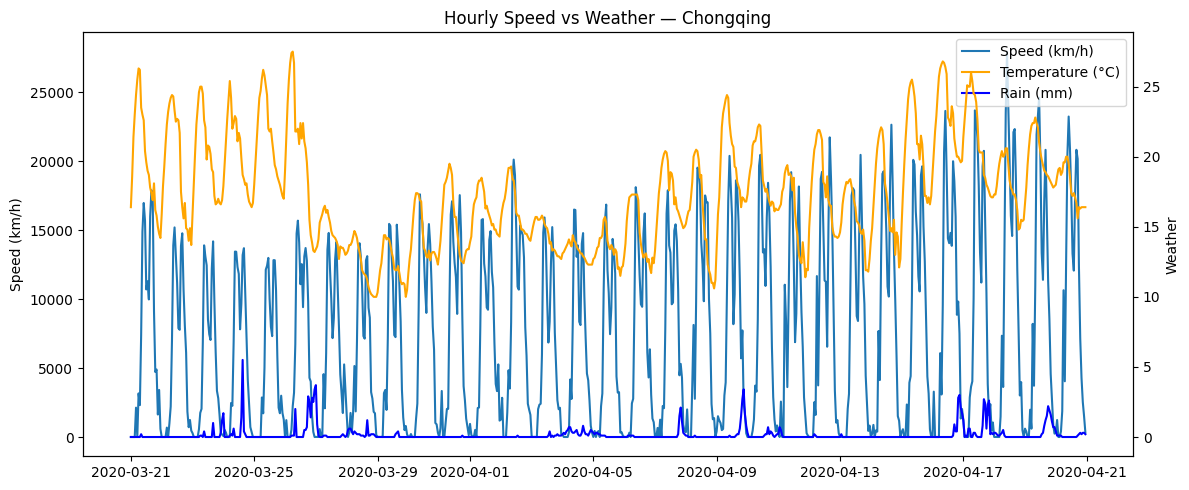

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(cq_hourly["datetime"], cq_hourly["speed_kmph"], label="Speed (km/h)")
ax1.set_ylabel("Speed (km/h)")

ax2 = ax1.twinx()
ax2.plot(cq_hourly["datetime"], cq_hourly["temperature"], label="Temperature (°C)", color="orange")
ax2.plot(cq_hourly["datetime"], cq_hourly["rain"], label="Rain (mm)", color="blue")
ax2.set_ylabel("Weather")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Hourly Speed vs Weather — Chongqing")
plt.tight_layout()
plt.show()


In [ ]:
# delivery_df_ch["receipt_timestamp"]=pd.to_datetime("2024-"+delivery_df_ch["receipt_time"],format="%Y-%m-%d %H:%M:%S")
# traj_spacegroup_df["start_timestamp"]=pd.to_datetime("2024-"+traj_spacegroup_df["start_time"],format="%Y-%m-%d %H:%M:%S")
# traj_spacegroup_df["end_timestamp"]=pd.to_datetime("2024-"+traj_spacegroup_df["end_time"],format="%Y-%m-%d %H:%M:%S")
# # spooky_df = traj_spacegroup_df[traj_spacegroup_df["mmdd_start"]!=traj_spacegroup_df["mmdd_end"]]

In [ ]:
# deliver_df_test_temp = delivery_df[delivery_df["delivery_user_id"]=="0008c2b6a2314db8715301b7eeeebc5a"]

In [ ]:
# #"0008c2b6a2314db8715301b7eeeebc5a"
# delivery_df_ch_instance = delivery_df_ch[delivery_df_ch["delivery_user_id"]=="0008c2b6a2314db8715301b7eeeebc5a"]
# traj_spacegroup_df_instance = traj_spacegroup_df[traj_spacegroup_df["postman_id"]=="0008c2b6a2314db8715301b7eeeebc5a"]

In [ ]:
# # merged = traj_spacegroup_df.merge(delivery_df, 
# #                          left_on="mmdd_start",
# #                          right_on="ds",
# #                          how="inner")

# merged = delivery_df_ch_instance.merge(
#     traj_spacegroup_df_instance,
#     left_on = "delivery_user_id",
#     right_on = "postman_id",
#     how="inner"
# )

# matched = merged[
#     (merged["receipt_timestamp"] >= merged["start_timestamp"]) &
#     (merged["receipt_timestamp"] <= merged["end_timestamp"])
# ]

In [ ]:
# delivery_cq_csv = pd.read_csv("./delivery/delivery_cq.csv")

# delivery_cq_csv_321 = delivery_cq_csv[delivery_cq_csv["ds"]==321]

In [ ]:
# import requests






In [ ]:
# # assume df has a column "ds" with values like 321, 405, 1205
# s = delivery_cq_csv["ds"].astype(str).str.zfill(4)          # "0321", "0405", "1205"
# delivery_cq_csv["month"] = s.str[:2]                        # "03", "04", "12"
# delivery_cq_csv["day"] = s.str[2:]                          # "21", "05", "05"

# # Build a real date with a fixed year (e.g., 2024)
# delivery_cq_csv["date"] = pd.to_datetime(
#     "2020-" + delivery_cq_csv["month"] + "-" + delivery_cq_csv["day"],
#     format="%Y-%m-%d"
# )

In [ ]:
# delivery_cq_csv["date"].min(),delivery_cq_csv["date"].max()

In [ ]:
# start_date = delivery_cq_csv["date"].min().strftime("%Y-%m-%d")
# end_date   = delivery_cq_csv["date"].max().strftime("%Y-%m-%d")

# lat = 30.90269
# lon = 108.71639

# url = (
#     "https://archive-api.open-meteo.com/v1/archive"
#     f"?latitude={lat}&longitude={lon}"
#     f"&start_date={start_date}&end_date={end_date}"
#     "&hourly=temperature_2m,relativehumidity_2m,precipitation,windspeed_10m"
# )

# data = requests.get(url).json()

In [ ]:
# weather_df = pd.DataFrame({
#     "datetime": pd.to_datetime(data["hourly"]["time"]),
#     "temp": data["hourly"]["temperature_2m"],
#     "humidity": data["hourly"]["relativehumidity_2m"],
#     "rain": data["hourly"]["precipitation"],
#     "wind_speed": data["hourly"]["windspeed_10m"],
# })

# weather_df["date"] = weather_df["datetime"].dt.date
# weather_df["hour"] = weather_df["datetime"].dt.hour

In [ ]:
# delivery_cq_csv["date"] = pd.to_datetime(delivery_cq_csv["date"])
# weather_df["date"] = pd.to_datetime(weather_df["date"])

# delivery_weather_df = delivery_cq_csv.merge(
#     weather_df,
#     on="date",
#     how="left"
# )

In [ ]:
# trj_max_time=traj_spacegroup_df["start_time"].max()
# traj_min_time=traj_spacegroup_df["start_time"].min()

# delivery_max_time = delivery_df["delivery_time"].max()
# delivery_min_time = delivery_df["delivery_time"].min()

In [ ]:
# delivery_df_check = delivery_df[(delivery_df["ds"]>=321) & (delivery_df["ds"]<=420)]

In [ ]:
# temp = pd.read_csv("./courier_detailed_trajectory/courier_detailed_trajectory.csv")

In [ ]:
# temp2 = pd.read_pickle("./data_with_trajectory_20s/delivery_five_cities.pkl.xz",compression="xz")

In [ ]:
# traj_df = pd.read_pickle("./data_with_trajectory_20s/courier_detailed_trajectory_20s.pkl.xz",compression="xz")

# # traj_df["gps_time"]=pd.to_datetime(traj_df["gps_time"])

# traj_gsort_df = (
#     traj_df.groupby("postman_id",group_keys=False)
#     .apply(lambda g:g.sort_values("gps_time"))
#     .reset_index(drop=True)
# )



# traj_basegroup_df = (
#     traj_df.groupby(["ds","postman_id"])
#     .size()
#     .reset_index(name="count_coordinates")
# )



In [ ]:
# traj_gsort_df["seq"]=(
#     traj_gsort_df.groupby("postman_id")[["lat","lng"]]
#     .apply(lambda g: (g != g.shift())).any(axis=1).cumsum()
#     .reset_index(level=0, drop=True)
# )


In [ ]:
# traj_spacegroup_df = (
#     traj_gsort_df.groupby(["postman_id","seq"])
#     .agg(
#         lat = ("lat","first"),
#         lng = ("lng","first"),
#         start_time = ("gps_time","min"),
#         end_time = ("gps_time","max"),
#         n_pings = ("gps_time","size")
#     )
#     .reset_index()
# )

In [ ]:
# traj_spacegroup_df.to_pickle("trajectory_spacegroup.pkl")